# Handwritten Digits Classification - Convolution Neural Network

## Dataset -Class Imbalanced MNIST
The MNIST database is a set of handwritten digit images. The digits have been size-normalized and centered in a fixed-size image (28x28). For more information refer to: http://yann.lecun.com/exdb/mnist/. An altered MNIST dataset will be used for this experiment. This dataset will have an imbalance of classes.

In [1]:
import helper
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight
%matplotlib inline

In [2]:
# Training Dataset
training_image_set, training_label_set = helper.get_data_from_file(False)

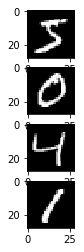

In [3]:
# Show examples
helper.show_set_of_images(training_image_set, training_label_set)

### Class Imbalance Visualisation
It is clear that there is a Class Imbalance. Class 7, 8 and 9 have around 720 images, whereas the other Classes (1,2,3,4,5 and 6) have between 5600 to 6400 images. 

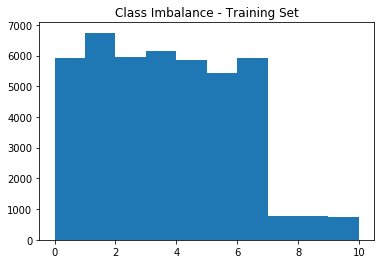

In [4]:
# Class Imbalance Visualisation
helper.plot_histogram(training_label_set, 'Class Imbalance - Training Set')

In [5]:
# Extracting a Validation Dataset from Training Dataset 
number_of_validation_images = math.floor(training_image_set.shape[0] * 0.10)

validation_image_set = training_image_set[-number_of_validation_images:]
training_image_set = training_image_set[:-number_of_validation_images]

validation_label_set = training_label_set[-number_of_validation_images:]
training_label_set = training_label_set[:-number_of_validation_images]

In [6]:
# Testing Dataset
test_image_set, test_label_set = helper.get_data_from_file(True)

## Convolution Neural Network - Using Keras with TensorFlow backend

In [7]:
import keras
from keras.datasets import mnist
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation

Using TensorFlow backend.


### Data Preparation

Creating a large matrix containing all images (in a dataset). This will form the input for the model.  

In [8]:
img_rows, img_cols = 28, 28
# Grayscale Image: 28 x 28 x 1
input_shape = (img_rows, img_cols, 1)

training_image_set = training_image_set.reshape(training_image_set.shape[0], img_rows, img_cols, 1)
validation_image_set = validation_image_set.reshape(validation_image_set.shape[0], img_rows, img_cols, 1)
test_image_set = test_image_set.reshape(test_image_set.shape[0], img_rows, img_cols, 1)

# Normalise Image - pixel values to the range 0 and 1
training_image_set /= 255
validation_image_set /= 255
test_image_set /= 255

One-Hot Encoding for 10 classes (0 to 9) the Labels. This transforms the scalar label value into a 10 x 1 vector, containing a 1 at the index of the scalar value. For example if the scalar label value is 3 then the encoded result would be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [9]:
# 0 to 9
num_classes = 10

# One-Hot Encoding of Labels
training_label_set_encoded = keras.utils.to_categorical(training_label_set, num_classes)
validation_label_set_encoded = keras.utils.to_categorical(validation_label_set, num_classes)
test_label_set_encoded = keras.utils.to_categorical(test_label_set, num_classes)

### Convolution Neural Network Model
Convolutional neural network will be used in order to retain the image structure.

The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, with the size of 3×3 and a ReLu activation function. This is the input layer, expecting images with size of 28 x 28 x 1.

Next, a convolutional layer. The layer has 64 feature maps, with the size of 3×3 and a ReLu activation function

Next, a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.

The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 25% of neurons in the layer in order to reduce overfitting.

Next, is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard(dense) fully connected layers.

Next, a fully connected layer with 128 neurons and ReLu activation function.

Next, a dropout layer, which will randomly exclude 25% neurons in the layer.

Next, a Batch Normalisation Layer.

Finally, the output layer has 10 neurons for the 10 classes and a Softmax activation function to output probability-like predictions for each class.

Optimiser: ADADELTA: An Adaptive Learning Rate Method (https://arxiv.org/abs/1212.5701)

In [10]:
def build_model(input_shape, num_classes):
    model = Sequential()
    # 2D Convolutional Layer.
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    # 2D Convolutional Layer.
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # 2D Max Pooling Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout Layer. Rate 25%
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # Dropout Layer. Rate 50%
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    # Batch Normalisation
    model.add(BatchNormalization())
    model.add(Activation("softmax"))
    
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
    return model

In [11]:
model = build_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Train Model
In order to manage the class imbalance, the model will be trained with a class weight used for scaling the loss function during training. The class weight can be calculated by taking the total number of images of a class divided by the total number of images in the training set. The dropout layers will also help with the imbalance by preventing the model to overfit on the training dataset.

In [12]:
batch_size = 256
epochs = 100
class_weight_list = class_weight.compute_class_weight('balanced', np.unique(training_label_set), training_label_set)
class_weight_dictionary = {}
for i in range(len(class_weight_list)):
    class_weight_dictionary[i] = class_weight_list[i]
training_results = model.fit(training_image_set, training_label_set_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          class_weight = class_weight_dictionary,
          validation_data=(validation_image_set, validation_label_set_encoded))

Train on 39800 samples, validate on 4422 samples
Epoch 1/100
39800/39800 [==============================] - 6s - loss: 0.7359 - acc: 0.8739 - val_loss: 1.2282 - val_acc: 0.9821
Epoch 2/100
39800/39800 [==============================] - 5s - loss: 0.4470 - acc: 0.9557 - val_loss: 0.6125 - val_acc: 0.9862
Epoch 3/100
39800/39800 [==============================] - 5s - loss: 0.3503 - acc: 0.9721 - val_loss: 0.3395 - val_acc: 0.9873
Epoch 4/100
39800/39800 [==============================] - 5s - loss: 0.2848 - acc: 0.9773 - val_loss: 0.2597 - val_acc: 0.9887
Epoch 5/100
39800/39800 [==============================] - 5s - loss: 0.2395 - acc: 0.9823 - val_loss: 0.1908 - val_acc: 0.9855
Epoch 6/100
39800/39800 [==============================] - 5s - loss: 0.2035 - acc: 0.9854 - val_loss: 0.1759 - val_acc: 0.9896
Epoch 7/100
39800/39800 [==============================] - 5s - loss: 0.1739 - acc: 0.9880 - val_loss: 0.1410 - val_acc: 0.9900
Epoch 8/100
39800/39800 [==============================

39800/39800 [==============================] - 5s - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0257 - val_acc: 0.9923
Epoch 65/100
39800/39800 [==============================] - 5s - loss: 0.0043 - acc: 0.9998 - val_loss: 0.0246 - val_acc: 0.9930
Epoch 66/100
39800/39800 [==============================] - 5s - loss: 0.0033 - acc: 0.9997 - val_loss: 0.0257 - val_acc: 0.9923
Epoch 67/100
39800/39800 [==============================] - 5s - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0258 - val_acc: 0.9923
Epoch 68/100
39800/39800 [==============================] - 5s - loss: 0.0032 - acc: 0.9998 - val_loss: 0.0280 - val_acc: 0.9925
Epoch 69/100
39800/39800 [==============================] - 5s - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0264 - val_acc: 0.9925
Epoch 70/100
39800/39800 [==============================] - 5s - loss: 0.0032 - acc: 0.9998 - val_loss: 0.0260 - val_acc: 0.9925
Epoch 71/100
39800/39800 [==============================] - 5s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0274

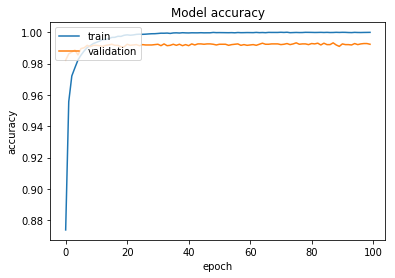

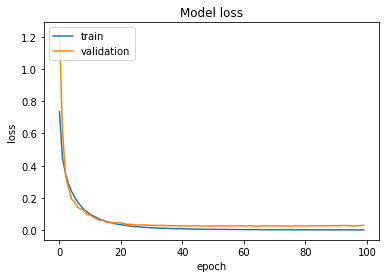

In [13]:
# plot model accuracy vs epoch 
plt.plot(training_results.history['acc'])
plt.plot(training_results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# plot model loss vs epoch
plt.plot(training_results.history['loss'])
plt.plot(training_results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Model Evaluation

In [14]:
score = model.evaluate(test_image_set, test_label_set_encoded, verbose=1)
print('')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
test_prediction_label = model.predict_classes(test_image_set)
print('')
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(np.argmax(test_label_set_encoded,axis=1), test_prediction_label,target_names=target_names))

 9856/10000 [============================>.] - ETA: 0s
Test loss: 0.0378042252488
Test accuracy: 0.9894
 9792/10000 [============================>.] - ETA: 0s
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       980
          1       0.99      1.00      1.00      1135
          2       0.98      1.00      0.99      1032
          3       0.99      1.00      0.99      1010
          4       0.98      1.00      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.98      0.98      1028
          8       0.99      0.98      0.99       974
          9       0.99      0.97      0.98      1009

avg / total       0.99      0.99      0.99     10000



#### Confusion matrix

Confusion matrix
[[ 979    0    0    0    0    0    1    0    0    0]
 [   0 1131    1    1    0    0    1    1    0    0]
 [   1    0 1027    0    1    0    0    2    1    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  979    0    1    0    0    2]
 [   1    0    0    4    0  885    2    0    0    0]
 [   4    2    0    1    1    2  947    0    1    0]
 [   0    4   16    0    2    0    0 1003    2    1]
 [   5    0    2    1    2    1    0    2  959    2]
 [   6    1    0    1    9    7    0    5    2  978]]
Confusion matrix (Normalised)
[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.99 

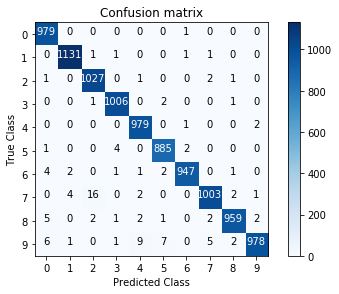

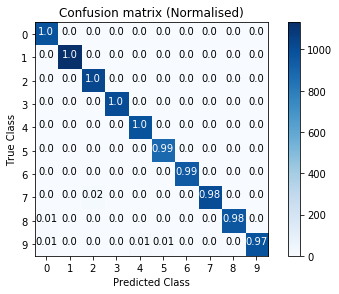

In [15]:
cnf_matrix = confusion_matrix(np.argmax(test_label_set_encoded,axis=1), test_prediction_label)

# Plot non-normalized confusion matrix
plt.figure()
helper.plot_confusion_matrix(cnf_matrix)

# Plot normalized confusion matrix
plt.figure()
helper.plot_confusion_matrix(cnf_matrix, normalise=True)

plt.show()